In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import arviz as az
import numpy as np
import polars as ps
import pymc as pm
from pytensor import shared
from sklearn.model_selection import train_test_split

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Data

In [5]:
dataset_dir: str = '/content/drive/MyDrive/'

In [6]:
type_map: list = [ps.Int32, ps.Int32, ps.Int32, ps.Int32, ps.Int32, ps.Int32, ps.Int32, 
                  ps.Int32, ps.Float32, ps.Float32, ps.Float32, ps.Float32, ps.Float32, 
                  ps.Float32, ps.Float32, ps.Float32, ps.Float32, ps.Float32, 
                  ps.Float32, ps.Int32, ps.Float32, ps.Float32, ps.Float32]

In [54]:
dataset: ps.DataFrame = ps.read_csv('{}full_dataset_train.csv'.format(dataset_dir), dtypes=type_map, encoding='utf8', n_threads=8, use_pyarrow=True)

In [55]:
dataset.head()

SiteId,PublishYear,PublishMonth,PublishDay,PublishHour,AQI,Pollutant,Status,SO2,SO2_AVG,CO,CO_8hr,O3,O3_8hr,PM10,PM10_AVG,NO,NO2,NOx,WindDirec,WindSpeed,PM2.5,PM2.5_AVG
i32,i32,i32,i32,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32
48,2022,6,1,0,27,0,0,0.9,1.0,0.3,0.1,1.7,14.3,19.0,17.0,3.9,16.5,20.4,85,0.9,7.0,5.0
58,2022,6,1,1,40,0,0,2.1,3.0,0.1,0.1,0.4,3.3,21.0,16.0,22.4,24.6,47.0,237,0.4,13.0,8.0
71,2022,6,1,1,37,0,0,2.1,1.0,0.3,0.2,0.0,7.2,22.0,18.0,6.0,22.200001,28.200001,253,0.5,8.0,7.0
15,2022,6,1,2,23,1,0,0.7,1.0,0.4,0.5,0.7,3.4,16.0,13.0,3.7,14.0,17.799999,70,0.3,9.0,7.0
8,2022,6,1,4,23,1,0,0.6,0.0,0.3,0.5,4.2,3.6,14.0,12.0,1.5,10.3,11.8,161,0.9,8.0,7.0


# Features

In [56]:
features: list = ['AQI', 'Status', 'PM10', 'PM10_AVG', 'PM2.5_AVG']
target_feature: str = 'PM2.5'

In [57]:
dataset = dataset.sample(n=150000, seed=37710)

In [58]:
variables: np.array = np.array([dataset[feature].to_numpy() for feature in features])
variables = variables.transpose()

In [59]:
target: np.array = dataset[target_feature].to_numpy().reshape(1, -1)
target = target.transpose()

In [60]:
train_variables, test_variables, train_target, test_target = train_test_split(variables, target, test_size=0.4, random_state=37710, shuffle=True)

In [61]:
train_variables = shared(train_variables.transpose())
train_target = train_target.transpose()
test_variables = test_variables
test_target = test_target

# Model

In [62]:
with pm.Model() as predictor:
	intercept = pm.Normal(name='intercept', sigma=10)
	coefficients = pm.Normal(name='coefficients', mu=0, sigma=1, shape=5)
	error = pm.HalfCauchy(name='error', beta=5)
	model = pm.Deterministic('model', intercept + pm.math.dot(coefficients, train_variables))
	
	prediction = pm.Normal(name='prediction', mu=model, sigma=error, observed=train_target)

	trace = trace = pm.sample(tune=2000, chains=2, random_seed=37710, cores=8, nuts_sampler='numpyro')
	ppc = pm.sample_posterior_predictive(trace, random_seed=37710)

/usr/local/lib/python3.10/dist-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...


/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:641: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:00.893602
Sampling...


sample: 100%|██████████| 3000/3000 [01:55<00:00, 25.96it/s, 63 steps of size 5.56e-02. acc. prob=0.93]


Sampling time =  0:04:06.470250
Transforming variables...
Transformation time =  0:00:00.031463


# Performance Analysis

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'coefficients'}>,
        <Axes: title={'center': 'coefficients'}>],
       [<Axes: title={'center': 'error'}>,
        <Axes: title={'center': 'error'}>]], dtype=object)

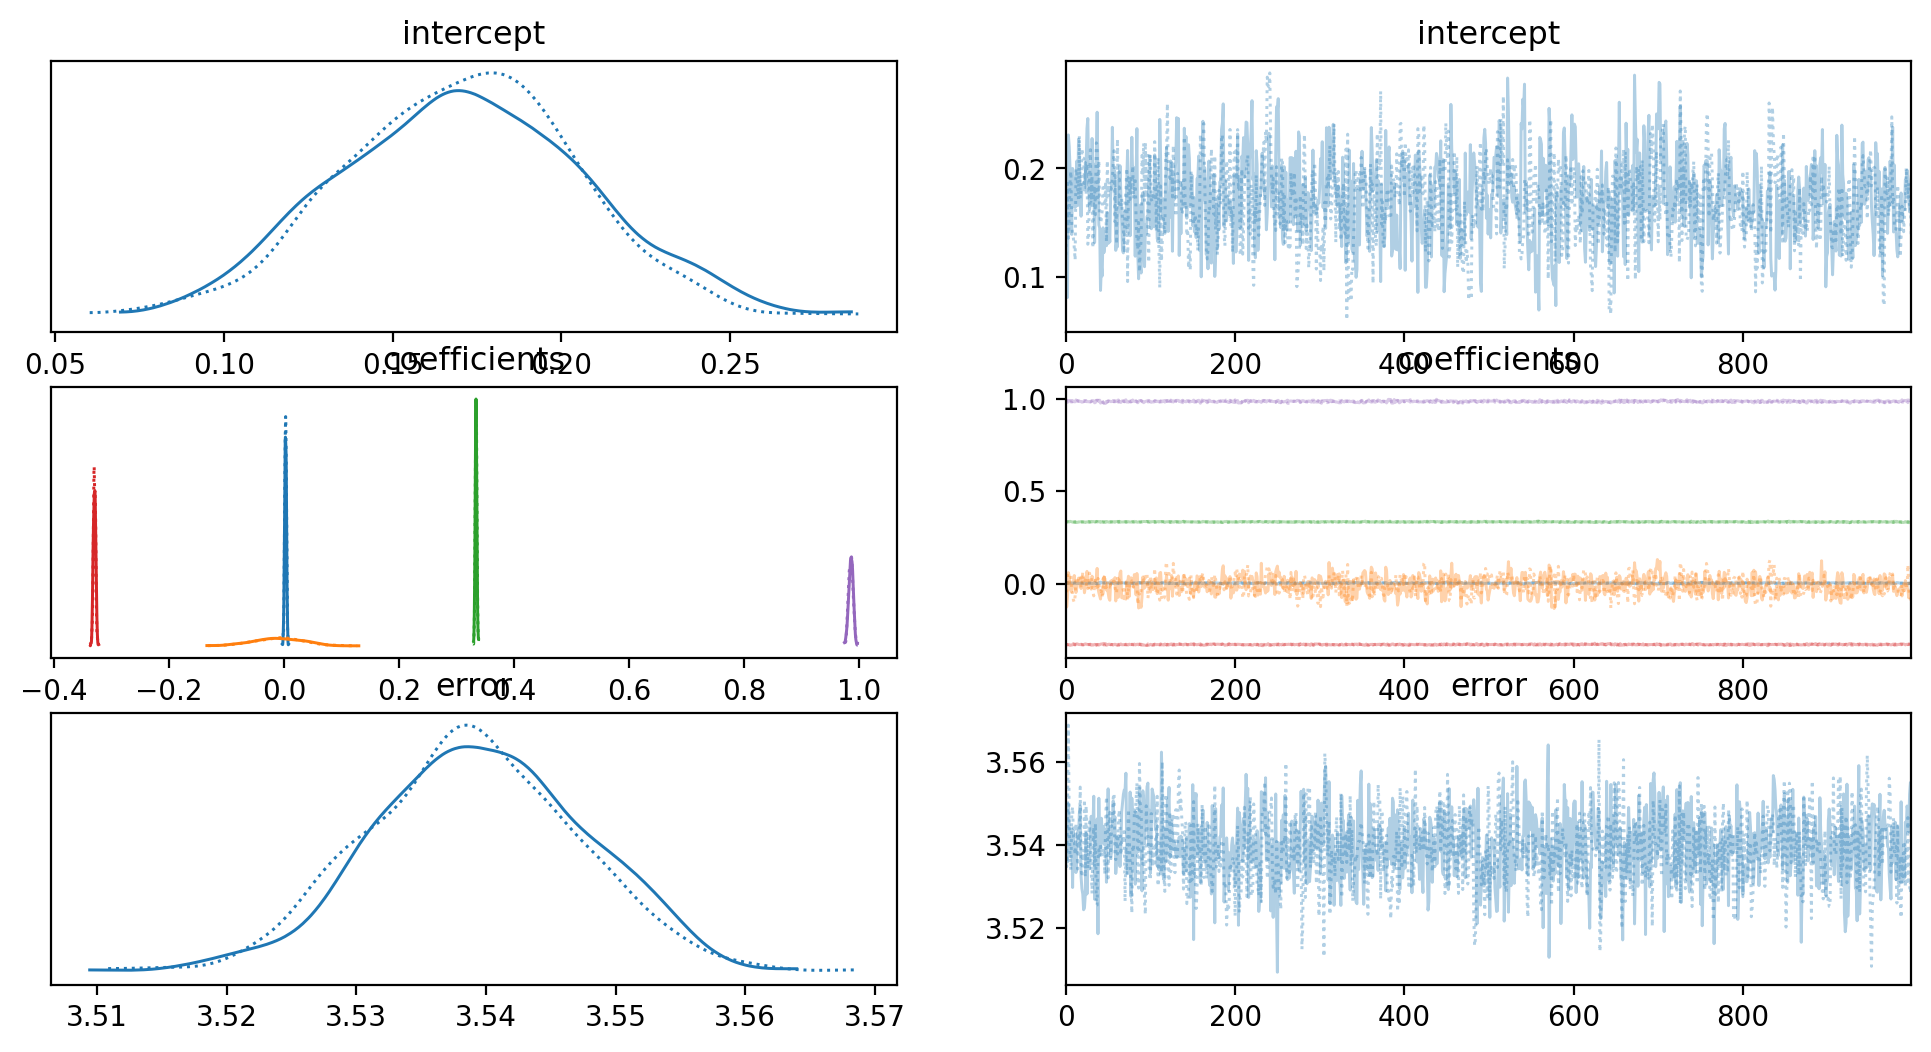

In [63]:
az.plot_trace(trace, var_names=['intercept', 'coefficients', 'error'])

In [64]:
summary = az.summary(trace, var_names=['intercept', 'coefficients', 'error'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.171,0.037,0.106,0.242,0.001,0.001,674.0,846.0,1.0
coefficients[0],0.003,0.002,-0.000,0.006,0.000,0.000,830.0,1264.0,1.0
coefficients[1],-0.009,0.044,-0.095,0.068,0.002,0.001,808.0,881.0,1.0
coefficients[2],0.334,0.001,0.331,0.336,0.000,0.000,1331.0,1134.0,1.0
coefficients[3],-0.329,0.002,-0.333,-0.325,0.000,0.000,936.0,1181.0,1.0
coefficients[4],0.985,0.004,0.978,0.991,0.000,0.000,991.0,1269.0,1.0
error,3.539,0.008,3.525,3.555,0.000,0.000,1141.0,1460.0,1.0


## MSE

In [65]:
def predict_function(test_variable: np.array, parameters: list) -> float:
	formula_intercept: float = parameters[0]
	formula_coefficients: np.array = np.array(parameters[1:-1]).reshape(-1, 1)
	return float(np.dot(test_variable.reshape(1, -1), formula_coefficients)) + formula_intercept

In [66]:
predictions: np.array = np.array([predict_function(variable, summary['mean'].to_list()) for variable in test_variables]).reshape(-1, 1)

In [67]:
def mean_square_error(target_prediction: list, target_truth: list) -> float:
	return np.square(np.subtract(target_prediction, target_truth)).mean()

In [68]:
print('MSE: {:.2f}'.format(mean_square_error(predictions, test_target)))

MSE: 13.02


## Test Data

In [ ]:
site: str = ''

In [ ]:
test_set: ps.DataFrame = ps.read_csv('{}}full_dataset_test.csv'.format(dataset_dir), dtypes=type_map, encoding='utf8', n_threads=8, use_pyarrow=True)

In [ ]:
test_set = test_set.filter(ps.col() == site)

In [ ]:
test_set.head()

In [ ]:
test_x: np.array = np.array([test_set[feature].to_numpy() for feature in features])
test_x = test_x.transpose()

In [ ]:
test_y: np.array = test_set[target_feature].to_numpy().reshape(1, -1)
test_y = test_y.transpose()

In [ ]:
test_predictions: np.array = np.array([predict_function(variable, summary['mean']) for variable in test_x]).reshape(-1, 1)

In [ ]:
print("Real Data Test's MSE: {:.2f}".format(mean_square_error(test_predictions, test_y)))